## Import packages and dataset

In [1]:
import pandas as pd
import sklearn as sk 
from sklearn.model_selection import train_test_split
import numpy as np 
import csv
import re
from sklearn import preprocessing
import matplotlib.pyplot as plt
import keras 
from keras.layers import *
from keras.models import Sequential
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5 
from eli5.sklearn import PermutationImportance

In [2]:
#import data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print('test size--->'+str(test.shape))
print('train size --->' +str(train.shape))

test size--->(418, 11)
train size --->(891, 12)


## Data preview

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


the 'titanic dataset ' have this information 
- Survived: Survived (1) or died (0)

- Pclass: Passenger’s class

- Name: Passenger’s name

- Sex: Passenger’s sex

- Age: Passenger’s age

- SibSp: Number of siblings/spouses aboard

- Parch: Number of parents/children aboard

- Ticket: Ticket number

- Fare: Fare

- Cabin: Cabin

- Embarked: Port of embarkation

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## check missing data 

In [5]:
for column in train : 
    null_data = train[column].isnull().sum()
    null_mean = null_data / len(train['PassengerId'])
    print (column + '='+ str(null_data )+ ' ----->'+str(round(null_mean , 2 )) + '%')

PassengerId=0 ----->0.0%
Survived=0 ----->0.0%
Pclass=0 ----->0.0%
Name=0 ----->0.0%
Sex=0 ----->0.0%
Age=177 ----->0.2%
SibSp=0 ----->0.0%
Parch=0 ----->0.0%
Ticket=0 ----->0.0%
Fare=0 ----->0.0%
Cabin=687 ----->0.77%
Embarked=2 ----->0.0%


we can see that the missing data are predominantly two : 

- Age : age of the passenger 
- Cabin : passenger cabin 

The age is certainly a missing data due to an oversight and covers only 0.22% of the data present. 

The information about the cabin (sector + number), could be due to a "non-assignment" of the cabin due to the fact that the last class had no accommodation. 
Let's verify this supposition. 

In [6]:
check_class =pd.DataFrame(train[["Pclass" , "Age" , "Cabin"]])
check_class['Age']= np.where(check_class["Age"].isnull(), 1, 0) 
check_class['Cabin']= np.where(check_class["Cabin"].isnull(), 1, 0) 
check_class.groupby(['Pclass' ])['Cabin', 'Age'].agg('sum')

<ipython-input-6-c14264617f2d>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  check_class.groupby(['Pclass' ])['Cabin', 'Age'].agg('sum')


,Cabin,Age
Pclass,,
1,40,30
2,168,11
3,479,136


as we can see the higher the class the more likely it is that a sector or cabin will not be assigned. 

For this reason I believe that the information "a booth has not been assigned" may be relevant to the analysis. 
So the lack of a sector will be replaced by putting " sector Z" , while the age will be replaced later by putting the most likely value using the fillna library.

The split_cabin function was created to split the section information (potentially very important as an indicator of social class and position at the time of impact) from the cabin information (not relevant and potentially misleading).

The section is then transformed into a numerical variable by assigning a number to the letters according to its position in the alphabet (A = 1 B=2 etc).


### control of the importance of each feature through a statistical analysis

In [7]:
def split_age(data):
    
    ### control of the importance of each feature through a statistical analysis
    
    data= np.where(data<= 10, 1 , data)
    data = np.where((data > 10)&(data <= 25) , 2 , data) 
    data = np.where((data > 25)&(data <= 50) , 3 , data)
    data = np.where((data > 50)&(data <= 80) , 4 , data)
    data = np.where((data > 80), 5 , data)
    print (data)
    '''
    data = np.where((data == 1), '0-10' , data)
    data = np.where((data == 2 ), '11-25' , data)
    data = np.where((data == 3 ), '25-50' , data)
    data = np.where((data == 4 ), '50-80' , data)
    data = np.where((data == 5 ), 'over 80' , data)
    print(data)
    
    '''
    return data


In [8]:
def split_age2(data):
    ### control of the importance of each feature through a statistical analysis (pivot)
    data['age_range']= np.where(data['Age']<= 10, '0-10' , data['Age'])
    data['age_range'] = np.where((data['Age'] > 10)&(data['Age'] <= 25) , '11-25' , data['age_range']) 
    data['age_range'] = np.where((data['Age'] > 25)&(data['Age'] <= 50) , '25-50' , data['age_range']) 
    data['age_range'] = np.where((data['Age'] > 50)&(data['Age'] <= 80) , '50-80' , data['age_range']) 
    data['age_range'] = np.where((data['Age'] > 80) , '80' , data['age_range']) 


    return data


In [9]:
def split_cabin (data): 
    
    # divide 'cabin' in section and number , attribute an additional section to the missing data 
    
    i = 0 
    for item in data['Cabin']:
        #print(item)
        temp=re.split('(\d+)',str(item))
        if len(temp) < 2 :
            temp.append('1')
        if len(temp[0])>1 :
            a = temp[0][0]
            temp[0] = a 
        if temp[0] == 'n' : 
            temp[0] = 'H'
        data.at[i , 'Cabin_Sector'] = num = ord(temp[0])- 64
        data.at[i , 'Cabin_Num'] = temp[1]  
        i = i+1 
        
    return data

In [10]:
check_db = train.copy()
check_db

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [11]:
#I create a copy of the DB to execute controls without modifying the train DB 

check_list = ['Pclass', 'Sex' , 'Age', 'SibSp' , 'Parch', 'Embarked' , 'age_range' , 'Cabin_Sector'] 
check_db = split_cabin(check_db)
check_db = split_age2(check_db)

check_db

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Sector,Cabin_Num,age_range
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,8.0,1,11-25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3.0,85,25-50
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,8.0,1,25-50
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.0,123,25-50
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,8.0,1,25-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,8.0,1,25-50
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2.0,42,11-25
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,8.0,1,nan
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3.0,148,25-50


-------Pclass--------
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


-------Sex--------
      Sex  Survived
0  female  0.742038
1    male  0.188908


-------Age--------
      Age  Survived
0    0.42       1.0
9    5.00       1.0
79  63.00       1.0
68  53.00       1.0
1    0.67       1.0
..    ...       ...
37  28.50       0.0
49  36.50       0.0
46  34.50       0.0
26  20.50       0.0
30  23.50       0.0

[88 rows x 2 columns]


-------SibSp--------
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


-------Parch--------
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


-------Embarked--------
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


-------age_range--------
  age_range  Survived
0      0-10  0.593750
2 

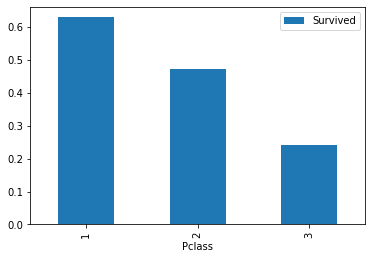

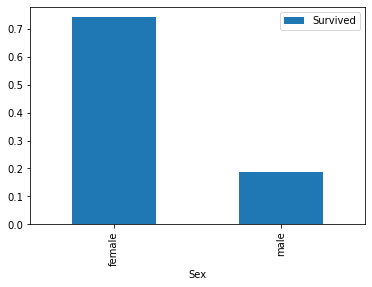

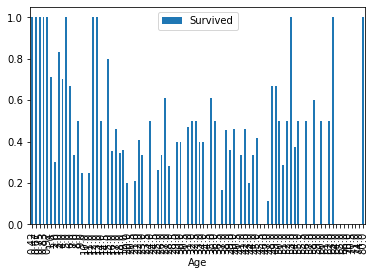

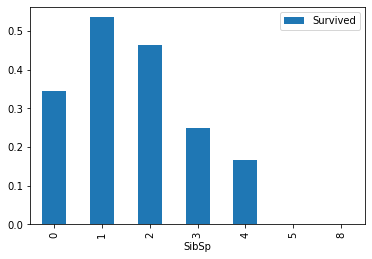

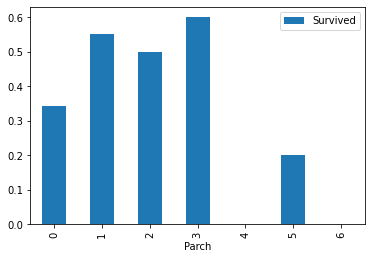

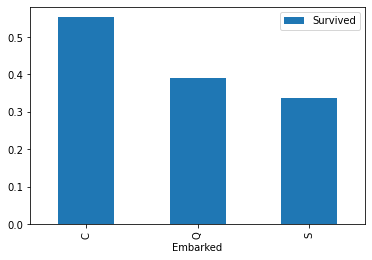

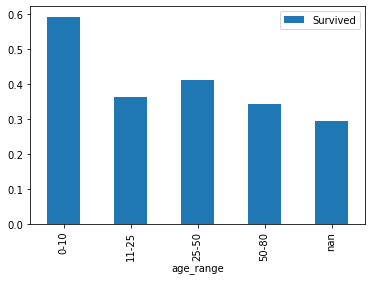

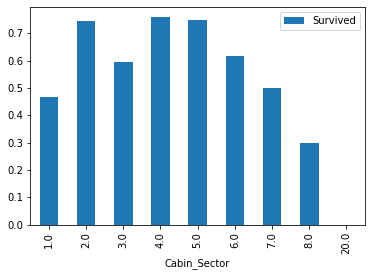

In [12]:
for i in check_list : 
    
    ## show pivot tables and histograms for each column 
    
    pivot = check_db[[i, 'Survived']].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False)
    table = pd.pivot_table(check_db,index=[i],values=['Survived'], aggfunc=np.mean)
    table.plot(kind='bar');


    print('-------' + str(i) + '--------')    
    print(pivot)
    
    print( '\n' )

In [13]:
## I convert the sexes to numerical data in order to make a correlation matrix 

check_db['Sex']=np.where(check_db['Sex'] == 'male' , 1 , 0)
check_db=pd.DataFrame(check_db ) 

# correlation Matrix 

check_db.corr()['Survived']

PassengerId    -0.005007
Survived        1.000000
Pclass         -0.338481
Sex            -0.543351
Age            -0.077221
SibSp          -0.035322
Parch           0.081629
Fare            0.257307
Cabin_Sector   -0.293473
Name: Survived, dtype: float64

## Interpretation of results
The correlation matrix highlights a correlation between the chance of surviving the accident and the following information: 
- Gender 
- class 
-Fare or ticket cost 
- Cabin sector 

The negative correlation of Pclass and the positive correlation Fare makes us think that wealthier people (first class and who spent a lot on the ticket ) had a good chance to save themselves.
Probably the cabins of the central sectors were the ones reserved to the most important people, in this way we can explain the correlation with the position of the sector  

We note that age is not in the " top four " instances. 
However if we look at the histogram we can see that the probability of surviving increases if you are an elderly person or a small child, however for other age groups is not relevant. 

Finally, we can note that it was much more likely to be saved from the accident if one was not alone but if one was traveling with children/parents. 



## first preparation of the Train dataset for predictive analysis 

In [15]:
le = sk.preprocessing.LabelEncoder()    


In [16]:
def prepare_data (data) : 
    #I add the cabin to those who do not have it 
    
    data['Cabin']= np.where(data["Cabin"].isnull(), 'Z1', data["Cabin"]) 
    split_cabin(data)
    
    #I convert the data "sex" with a numeric variable 
    
    data['Sex'] = np.where(data['Sex'] == 'male' , 1 , 0, )
    
    #replace the missing data "age" and " embarked " with the most probable data 


    data["Age"] = data["Age"].fillna(data["Age"].median()) #fill missing values with median age
    data["Embarked"] = data["Embarked"].fillna("S") 
    
    
    data["Sex"] = le.fit_transform(data["Sex"]) 
    data["Embarked"] = le.fit_transform(data["Embarked"])
    return data 

In [17]:
train = prepare_data (train)
test = prepare_data (test )

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Sector,Cabin_Num
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,Z1,2,26.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,3.0,85
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,Z1,2,26.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,3.0,123
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,Z1,2,26.0,1


In [19]:
X_train = train[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked", "Cabin_Sector"]]
columns_train = X_train.columns.tolist()
#X_train = train[["Pclass","Sex","Age"]]
X_train = X_train.values
y_train = train[["Survived"]].values
X_train = sk.preprocessing.scale(X_train)

## Model creation and training (MLP) 

In [20]:
def base_model():
    model = Sequential()        



    model.add(Dense(32,
                    kernel_initializer = "he_uniform",
                    bias_initializer = "zeros",
                    #kernel_regularizer=regularizers.l2(0.01),
                    activation = "relu",
                    input_dim = X_train.shape[1] ))
    model.add(Dropout(0.5))

    model.add(Dense(32,
                    kernel_initializer = "he_uniform",
                    bias_initializer = "zeros",
                    #kernel_regularizer=regularizers.l2(0.01),
                    activation = "relu",
                    ))
    model.add(Dropout(0.5))

    model.add(Dense(32,
                    kernel_initializer = "he_uniform",
                    bias_initializer = "zeros",
                    #kernel_regularizer=regularizers.l2(0.01),
                    activation = "relu",
                    ))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation = "sigmoid"))

    # opt = optimizers.Adam(lr = 0.0001,decay = 0, beta_1=0.9, beta_2=0.999, 
     #                      epsilon = None, amsgrad = True)
   # lr = 0.01
   # epochs = 30
   # decay = lr / epochs
   # momentum = 0.8
   # opt= tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=False)
    # opt = optimizers.Adam(lr = 0lr,decay = decady, beta_1=0.9, beta_2=0.999, 
    #                       epsilon = None, amsgrad = True)
    #opt = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=False)
    #opt = optimizers.SGD(lr=0.001)
    opt= 'adam' 
    model.compile(loss = "binary_crossentropy", optimizer = opt, 
                  metrics = ["accuracy"])
    
    
    stop = EarlyStopping(monitor = 'val_loss', patience = 100, verbose = 1)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.33, shuffle = True, 
        verbose = 1, batch_size = 8, callbacks = [stop])
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
    
    
    return model



<ipython-input-21-6f2767306c1d>:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  my_model = KerasRegressor(build_fn=base_model, epochs=100, batch_size=5,verbose=0)


Epoch 1/100
75/75 [==============================] - 1s 2ms/step - loss: 1.2586 - accuracy: 0.5470 - val_loss: 0.6597 - val_accuracy: 0.6475
Epoch 2/100
75/75 [==============================] - 0s 1ms/step - loss: 0.9823 - accuracy: 0.5721 - val_loss: 0.6229 - val_accuracy: 0.7356
Epoch 3/100
75/75 [==============================] - 0s 1ms/step - loss: 0.9580 - accuracy: 0.5638 - val_loss: 0.6006 - val_accuracy: 0.7254
Epoch 4/100
75/75 [==============================] - 0s 1ms/step - loss: 0.8495 - accuracy: 0.5805 - val_loss: 0.5847 - val_accuracy: 0.7593
Epoch 5/100
75/75 [==============================] - 0s 1ms/step - loss: 0.8268 - accuracy: 0.6107 - val_loss: 0.5790 - val_accuracy: 0.7763
Epoch 6/100
75/75 [==============================] - 0s 1ms/step - loss: 0.7198 - accuracy: 0.6309 - val_loss: 0.5789 - val_accuracy: 0.7729
Epoch 7/100
75/75 [==============================] - 0s 1ms/step - loss: 0.7337 - accuracy: 0.6409 - val_loss: 0.5777 - val_accuracy: 0.7898
Epoch 8/100
7

Epoch 59/100
75/75 [==============================] - 0s 1ms/step - loss: 0.4985 - accuracy: 0.7735 - val_loss: 0.4461 - val_accuracy: 0.8034
Epoch 60/100
75/75 [==============================] - 0s 1ms/step - loss: 0.5034 - accuracy: 0.7869 - val_loss: 0.4372 - val_accuracy: 0.8203
Epoch 61/100
75/75 [==============================] - 0s 1ms/step - loss: 0.5019 - accuracy: 0.7735 - val_loss: 0.4447 - val_accuracy: 0.8136
Epoch 62/100
75/75 [==============================] - 0s 1ms/step - loss: 0.4903 - accuracy: 0.7919 - val_loss: 0.4434 - val_accuracy: 0.8169
Epoch 63/100
75/75 [==============================] - 0s 1ms/step - loss: 0.5153 - accuracy: 0.7953 - val_loss: 0.4475 - val_accuracy: 0.8136
Epoch 64/100
75/75 [==============================] - 0s 1ms/step - loss: 0.4985 - accuracy: 0.7768 - val_loss: 0.4470 - val_accuracy: 0.8136
Epoch 65/100
75/75 [==============================] - 0s 1ms/step - loss: 0.4748 - accuracy: 0.8104 - val_loss: 0.4416 - val_accuracy: 0.8169
Epoch 

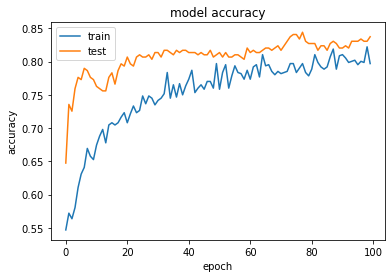

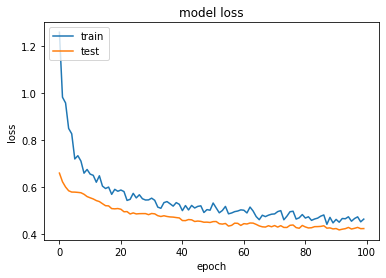

In [21]:
X = X_train
y = y_train

my_model = KerasRegressor(build_fn=base_model, epochs=100, batch_size=5,verbose=0)    
my_model.fit(X,y)



Now we can show the weights attributed to each feature, thus estimating its relevance according to its predictive power 

In [22]:
perm = PermutationImportance(my_model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names =columns_train)

Weight,Feature
0.3725 ± 0.0241,Sex
0.1744 ± 0.0496,Pclass
0.0745 ± 0.0130,Age
0.0376 ± 0.0107,SibSp
0.0334 ± 0.0057,Cabin_Sector
0.0267 ± 0.0061,Parch
0.0237 ± 0.0047,Fare
0.0159 ± 0.0030,Embarked


sex , class of membership and age are of enormous importance for prediction. 
However, as mentioned at the beginning, the sector of belonging is not negligible. 